In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

data = pd.read_csv('flights.csv')

# просмотрим базовую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   flight_id         118 non-null    int64  
 1   arrival_airport   118 non-null    object 
 2   model             118 non-null    object 
 3   duration_in_mins  118 non-null    int64  
 4   places_taken      118 non-null    int64  
 5   amount            118 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 5.7+ KB


## Вывод:
#### В датасете 2 строковых столбца, 1 столбцов типа float, 3 столбца типа int
#### В датасете содержится 118 строк (записей)

## Вспомогательные функции

In [96]:

def values_inside_iqr_for(series):
    median = series.median()
    print('Медиана ' + series.name + ' = ' + str(median))
    top_quantile = series.quantile(0.75)
    bottom_quantile = series.quantile(0.25)
    iqr = top_quantile - bottom_quantile
    print('IQR ' + series.name + ' = ' + str(iqr))
    lower_bound = bottom_quantile - (1.5 * iqr)
    upper_bound = top_quantile + (1.5 * iqr)
    print('Нижняя граница выброса ' + series.name + ' = ' + str(lower_bound))
    print('Верхняя граница выброса ' + series.name + ' = ' + str(upper_bound))
    return series.between(lower_bound, upper_bound)
    
def display_normalized_values_for(series):
    print(data[series.name].value_counts(dropna=False, normalize=True).head(10))

## Разберем основные столбцы

### Аэропорты прибытия (arrival_airport)

In [97]:
print(data.arrival_airport.value_counts(dropna=False))
print(data.arrival_airport.describe())

EGO    59
SVO    59
Name: arrival_airport, dtype: int64
count     118
unique      2
top       EGO
freq       59
Name: arrival_airport, dtype: object


### Вывод:
#### Представлены 2 направления: EGO (Белгород) и SVO (Шереметьево). Отсутсвующих значений нет

### Модели самолетов (model)

In [98]:
print(data.model.value_counts(dropna=False))
print(data.model.describe())

Sukhoi Superjet-100    59
Boeing 737-300         59
Name: model, dtype: int64
count                     118
unique                      2
top       Sukhoi Superjet-100
freq                       59
Name: model, dtype: object


### Вывод:
#### Всего представлены две модели самолетов: Sukhoi Superjet-100 и Boeing 737-300. Отсутсвующих значений нет

### Длительность каждого рейса (duration_in_mins)

50     34
100    27
99     17
51     15
49     10
101     8
98      4
102     2
103     1
Name: duration_in_mins, dtype: int64
count    118.000000
mean      74.957627
std       24.992783
min       49.000000
25%       50.000000
50%       74.500000
75%      100.000000
max      103.000000
Name: duration_in_mins, dtype: float64


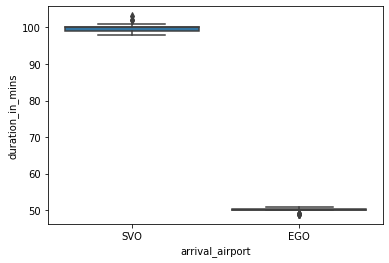

In [99]:
print(data.duration_in_mins.value_counts())
sns.boxplot(x='arrival_airport', y='duration_in_mins', data=data)
print(data.duration_in_mins.describe())


### Вывод:
#### Видим что в среднем полет до аэропорта SVO занимает от 98 до 103 минут, до аэропорта EGO от 49-51 минуту. Выбросов или пропущенных значений нет.

### Количество пассажиров на рейсе (places_taken)

97     0.152542
96     0.084746
87     0.042373
110    0.033898
95     0.033898
106    0.033898
115    0.033898
109    0.033898
94     0.025424
79     0.025424
Name: places_taken, dtype: float64
count    118.000000
mean     101.652542
std       14.295643
min       64.000000
25%       95.000000
50%       97.000000
75%      111.750000
max      130.000000
Name: places_taken, dtype: float64


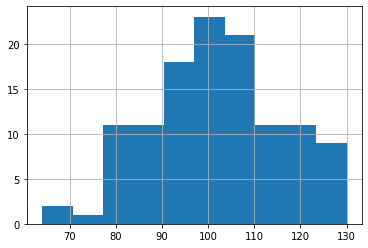

In [100]:
display_normalized_values_for(data.places_taken)
data.places_taken.hist()
print(data.places_taken.describe())

### Вывод:
#### Видим нормальное распределение пассажиров на рейсах. Выбросов нет (учитывая различную пассажировместимость моделей самолетов). Минимальное количество пассажиров на рейсе - 64, максимальное - 130. Отсутсвующих значений нет

## Добавим внешние данные

### Количество мест в самолетах на рейсе:

In [101]:
# данные из Google о модели самолета
model_seats_count = {'Sukhoi Superjet-100': 98, 
                     'Boeing 737-300': 149}

if 'seats_in_plane' not in data.columns:
    seats_in_plane = data.model.apply(lambda x: model_seats_count[x])
    data.insert(4, 'seats_in_plane', seats_in_plane)
    
    #так же добавим количество пустых мест на рейсе
    free_seats = data.seats_in_plane - data.places_taken
    data.insert(6, 'free_seats', free_seats)

### Количество потребляемого самолетом топлива и его стоимость:

In [102]:
# данные из Wikipedia о модели самолета
model_fuel_consumption = {'Sukhoi Superjet-100': 1700,
                          'Boeing 737-300': 2400}

if 'fuel_consumption' not in data.columns:
    hour_fuel_consumption = data.model.apply(lambda x: model_fuel_consumption[x])

    # рассчитаем количество потребляемого топлива за рейс
    flight_fuel_consumption = (data.duration_in_mins / 60) * hour_fuel_consumption
    data.insert(3, 'fuel_consumption', flight_fuel_consumption)
    
    # рассчитаем стоимость топлива на рейс. данные о стоимости взяты с 
    # https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm/
    # Видим что для Анапы стоимость составляет 41 754 рубля за тонну. (без НДС, но я не силен в экономике РФ, поэтому оставим так)
    # Умножим стоимость на 1.2, так как самолеты явно заполняют с запасом + погрешности физических свойств топлива
    # в зависимости от температуры, а так же разный расход в зависимости от условий полета
    fuel_price = (data.fuel_consumption * 41754 / 1000) * 1.2
    data.insert(4, 'fuel_price', fuel_price)

### Рассчитаем прибыль на основании стоимости топлива (с учетом доп затрат) и стоимости всех купленных билетов на рейс

In [109]:
data['income'] = data.amount - data.fuel_price

,flight_id,arrival_airport,model,fuel_consumption,fuel_price,duration_in_mins,seats_in_plane,places_taken,free_seats,amount,income


## Рассмотрим новые данные

### Количество пустых мест на рейсе

In [110]:
# убедимся что количество пустых мест на рейсе не имеет значений ниже 0
len(data[data.places_taken<0])

0

In [ ]:
# f_education
print(data.f_education.value_counts())
display(data.f_education.hist(bins=4))
print(data.f_education.describe())
# Видим в этом столбце выброс в виде значения 40. 
# предположим что это ошибочное значение, правильное значение должно быть 4 (высшее образование)
data.loc[(data['f_education'] == 40), 'f_education'] = 4

#рассмотрим отсутсвующие данные
display_absent_values_for(data.f_education)

#для отсутствующих значений используем тот же прием, что и с образованием матери
#т.e. предположим что образование отца соответствует образованию матери
data.f_education = np.where(data.f_education.isna(), data['m_education'], data['f_education'])

# аналогично с матерями, отцов без образования всего 2 и следовало бы их исключить из списка
# поскольку данных мало для объективного анализа, однако так же оставим их, чтобы увидеть результаты
# (хоть мы и знаем что вряд ли их можно будет назвать объективными)

In [ ]:
# traveltime
print(data.traveltime.value_counts())
data.traveltime.hist()
display_normalized_values_for(data.traveltime)

# видим что часть данных отсутсвует, рассмотрим отстутвующие данные
display_absent_values_for(data.traveltime)

# заменим отсутсвующие данные в зависимости от типа места жительства
# очевидно, что живущие в городе тратят меньше времени на путь в школу, чем живущие в деревне
# найдем медианные значения для каждого из типов места жительства, и заменим отсутсвующие значения
data.groupby(by=['address'])['traveltime'].median()

# видим что для деревни traveltime составляет 2, для города 1
# если тип адреса так же неизвестен, то опустим такую строку
data = data.dropna(subset=['address', 'traveltime'], how='all')
data.loc[(data['address'] == 'U') & (data['traveltime'].isna()), 'traveltime'] = 1
data.loc[(data['address'] == 'R') & (data['traveltime'].isna()), 'traveltime'] = 2

# видим что 2% (7) учеников тратят очень много времени на путь до школы. посмотрим какие результаты они в итоге покажут

In [ ]:
# studytime
print(data.studytime.value_counts())
print(data.studytime.describe())
data.studytime.hist()
# видим что подавляющее большинство учеников занимаются дополнительно 2-5 часов (2)
# часть данных отсутсвует. рассмотрим отсутсвующие данные

display_absent_values_for(data.studytime)

# считаю что данные о дополнитльном обучении достаточно важная информация, 
# которая оказывает существенное влияние на итоговый результат, поэтому замена
# отсутсвующих данных может существенно исказать результат,
# в связи с этим отбросим записи с отсутсвующими данными,
# к тому же, в каждой из данных строк отсутсвует большое количество информации и 
# по остальным признакам
data = data.dropna(subset=['studytime'], how='all')

In [ ]:
# failures
print(data.failures.value_counts())
data.failures.hist()
display_normalized_values_for(data.failures)

# видим что 75% учеников не испытвали внешкольных неудач. 5% данных отсутсвует
# достаточно сложно интерпретировать данные из этого столбца,
# поэтому предлагаю заменить отсутсвующие данные на значение моды (0)
data.failures = data.failures.fillna(0)

In [ ]:
# studytime_granular
data.studytime_granular.hist()
display_normalized_values_for(data.studytime_granular)

# если я правильно понимаю, то этот столбец содержит значение часов из столбцa studytime
# мы уже обработали столбец studytime, по сути эти данные просто дублируются
# (к тому же, почему-то со значением -), поэтому удалим этот столбец

data.drop(['studytime_granular'], inplace=True, axis=1)

In [ ]:
# family_relations
print(data.family_relations.describe())
display_normalized_values_for(data.family_relations)

# видим отрицательное значение -1, предположим что значение должно быть положительным и исправим это
data.loc[(data['family_relations'] == -1), 'family_relations'] = 1

# видим что отсутсвует около 7% данных, что довольно много, рассмотрим их
display_absent_values_for(data.family_relations)

# предлагаю удалить строки, в которых нет данных о семейных отношениях
# и семейной помощи в обучении (family_support), поскольку это достаточно важная информация
# которая оказывает существенное влияние
data = data.dropna(subset=['family_relations', 'family_support'], how='all')

# рассмотрим зависимость семейных отношений и совместного/раздельного проживания родителей
sns.boxplot(x ='parents_status', y = 'family_relations', data = data)

# очевидно, что в семьях где родители живут раздельно, отношения чуть хуже
# однако медианное значение для таких семей = 4.
# поэтому предлагаю заменить отсутсвующие значения в family_relations
# в семьях где родители живут вместе на 5, а где раздельно - на 4
data.loc[(data['parents_status'] == 'A') & (data['family_relations'].isna()), 'family_relations'] = 4
data.loc[(data['parents_status'] == 'T') & (data['family_relations'].isna()), 'family_relations'] = 5

In [ ]:
# freetime
print(data.freetime.value_counts())
data.freetime.hist()
display_normalized_values_for(data.freetime)

# видим что отсутствует небольшая часть значений (2.5%), рассмотрим их
display_absent_values_for(data.freetime)

# полагаю что будет логичным заменить отсутсвующие значения в данном случае
# на значения из столбца go_out. поскольку очевидно что если ты проводишь много времени с друзьями
# то у тебя много свободного времени, и наоборот :)
data.freetime = np.where(data.freetime.isna(), data['go_out'], data['freetime'])

In [ ]:
# go_out
print(data.go_out.value_counts())
data.go_out.hist()
display_normalized_values_for(data.go_out)

# видим что отсутствует небольшая часть значений (1.8%), рассмотрим их
display_absent_values_for(data.go_out)

# поступим аналогично предыдущему случаю, и подставим вместо отсутсвующих значений
# значения из столбца freetime
data.go_out = np.where(data.go_out.isna(), data['freetime'], data['go_out'])

In [ ]:
# health
print(data.health.describe())
display_normalized_values_for(data.health)
data.health.hist()

# видим что бОльшая часть студентов чувствуют себя замечательно
# и можем лишь посочувствовать 22% у которых не все хорошо со здоровьем
# пока нет понимания как можно заменить отсутсвующие значения,
# возможно следовало бы удалить строки с отсутвующими данными по здоровью,
# поскольку это весьма важный фактор, который нельзя не учитывать,
# однако пока предлагаю оставить как есть, возможно в дальнейшем мы как-либо обработаем эти данные

In [ ]:
# absences
print(data.absences.describe())
display_normalized_values_for(data.absences)
data.absences.hist()

# очевидны проблемы с этим столбцом, сразу же явно видны выбросы
# (ну либо они просто перестали ходить в школу :) )
# поэтому избавимся от выбросов
data = data.loc[values_inside_iqr_for(data.absences)]

display_absent_values_for(data.absences)

#отсутвующих значений нет

In [ ]:
# score
print(data.score.describe())
display_normalized_values_for(data.score)
data.score.hist()

# явно видно нормальное распределение оценок, при этом имеются
# выбросы/отсутсвующие данные в виде оценок 0, избавимся от них
data = data.loc[values_inside_iqr_for(data.score)]

# в результате этого мы так же избавились от результата 100
# (верхняя граница 98.125), но предлагаю не рассматривать вундеркиндов,
# а исследовать обычных студентов/школьников :)

In [ ]:
## подведем итоги обработки числовых столбцов
data.info()

# видим что в результате обработки всех числовых столбцов мы исключили ряд записей
# по разным причинам. Осталось 302 записи

In [ ]:
## Обработка строковых столбцов

In [ ]:
# school
display(data.school.value_counts())
display_normalized_values_for(data.school)

# видим, что 88% учеников обучаются в школе GP (что бы это ни значило). отсутсвующих/пустых значений нет


In [ ]:
# sex

display(data.sex.value_counts())
display_normalized_values_for(data.sex)

# видим что соотношение мальчиков и девочек примерно равное. отсутсвующих/пустых значений нет

In [ ]:
# address
display(data.address.value_counts())
display_normalized_values_for(data.address)

# видим что соотношение городских учеников к сельским примерно 3 к 1. Есть 3% пропущенных значений. 
# часть пропусков нами уже была обработана при анализе столбцa traveltime.
# рассмотрим оставшиеся пропуски

display_absent_values_for(data.address)

# для обработки пропусков в данном столбце используем тот же прием, что и при заполнении пропусков
# в столбце traveltime (1 - для городского жителя, 2 - для сельского)
data.loc[(data['traveltime'] == 1) & (data['address'].isna()), 'address'] = 'U'
data.loc[(data['traveltime'] == 2) & (data['address'].isna()), 'address'] = 'R'

In [ ]:
# family size
display(data.family_size.value_counts())
display_normalized_values_for(data.family_size)

# видим что 65% учеников проживают в больших семьях. 5% данных отсутсвуют
# рассмотрим оставшиеся пропуски

display_absent_values_for(data.family_size)

# учитывая что большинство учеников из больших семей, предлагаю заменить отсутсвующие значения 
# на GT3, если родители живут вместе (parents_status == T), и на LE3, если раздельно
# если данные о родителях так же отсутсвуют - удалим такие строки
data = data.dropna(subset=['parents_status', 'family_size'], how='all')
data.loc[(data['parents_status'] == 'A') & (data['family_size'].isna()), 'family_size'] = 'LE3'
data.loc[(data['parents_status'] == 'T') & (data['family_size'].isna()), 'family_size'] = 'GT3'

In [ ]:
# parents_status
display(data.parents_status.value_counts())
display_normalized_values_for(data.parents_status)
data.parents_status.hist()

# видим что в 80% случаев родители живут вместе. 9% данных отсутсвует, 9% живут раздельно
# рассмотрим оставшиеся пропуски

display_absent_values_for(data.parents_status)

# можно было бы следовать логике, обратной логике с размером семьи, но поскольку
# подавляющее большинство родителей живут вместе, заменим пропуски на значение моды
data.parents_status = data.parents_status.fillna(data.parents_status.mode()[0])

In [ ]:
# m_job
print(data.m_job.value_counts())
display_normalized_values_for(data.m_job)
display(data.m_job.hist())

# видим что 4% информации отсутсвует, рассмотрим отсутвующие данные
display_absent_values_for(data.m_job)

# думаю, наиболее правильным вариантом в данном случае будет заменить пропуски в работе матери
# на работу отца. не думаю, что эти значения окажут какое-то сильное влияние на конечный результат.
# в случае отсутсвия обоих данных - удалим такие строки
data = data.dropna(subset=['m_job', 'f_job'], how='all')
data.m_job = np.where(data.m_job.isna(), data['f_job'], data['m_job'])

In [ ]:
# f_job
display_normalized_values_for(data.f_job)
display(data.f_job.hist())

# видим что 8% информации отсутсвует, рассмотрим отсутвующие данные
display_absent_values_for(data.f_job)

# у меня появилась другая идея, привязать работу родителя к его уровню образования.
# оставим замену для работы матери как есть, поскольку там пропущенных значений в 2 раза меньше
# чем для работы отца, а для работы отца применим подход где
# уровень образования 4 - health, 3 - teacher, 2 - services, 1 - at_home

values_dictionary = {
    4: 'health',
    3: 'teacher',
    2: 'services',
    1: 'at_home'
}
for key, value in values_dictionary.items():
    data.loc[(data['f_education'] == key) & (data['f_job'].isna()), 'f_job'] = value

In [ ]:
# reason
display(data.reason.value_counts())
display_normalized_values_for(data.reason)

# видим что 4% информации отсутсвует, рассмотрим отсутвующие данные
display_absent_values_for(data.reason)

# сложно делать какие-либо выводы об этом столбце, да и не думаю что он имеет отношение
# к оценкам. возможно имеет отношение пункт 'course', то есть образовательная программа,
# но это не значит что в других школах она хуже, просто кто-то руководствуется
# другими причинами при выборе школы. 
# позволю себе удалить данный столбец как нерелевантный
data.drop(['reason'], inplace=True, axis=1)

In [ ]:
# guardian
display(data.guardian.value_counts())
display_normalized_values_for(data.guardian)

# данный столбец мне не совсем понятен. что значит опекун мать/отец
# если семья полная, то очевидно что оба родителя выполняют свои функции, а не кто-то один
# однако все же рассмотрим отсутсвующие значения, возможно найдем способ для замены данных
display_absent_values_for(data.guardian)

# сложно предположить какие-либо варианты для замены. удалим этот столбец
data.drop(['guardian'], inplace=True, axis=1)

In [ ]:
# school_support
display(data.school_support.value_counts())
display_normalized_values_for(data.school_support)

#видим что в большинстве случаев дополнительной поддержки нет. при этом небольшая часть данных (2.5%) пропущена
# рассмотрим отсутсвующие данные

display_absent_values_for(data.school_support)

#  возможно, наличие поддержки связано с типом школы. проверим эту гипотезу
data.groupby(by=['school_support'])['school'].hist()

# видим что поддержка есть только в школе GP, однако в связи с малочисленностью 
# данных о наличии поддержки мы не можем однозначно сказать что все остальные данные можно 
# заменить на наличие поддержки. Поскольку в школе MS данных о поддержке нет
# то в ней мы заменим отсутвующее значение на 'no'
data.loc[(data['school'] == 'MS') & (data['school_support'].isna()), 'school_support'] = 'no'

# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.school_support)

In [ ]:
# family_support
display(data.family_support.value_counts())
display_normalized_values_for(data.family_support)

# видим что в отличие от школьной поддержки, более половины учеников занимаются в семье
# 8% данных пропущено, рассмотрим их
display_absent_values_for(data.family_support)

# на данный момент не представляется возможным как-либо заполнить пропуски

# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.family_support)

In [ ]:
# paid
display(data.paid.value_counts())
display_normalized_values_for(data.paid)

# видим что распределение учеников с платными занятиями и без них приблизительно равное, при этом 11% данных пропущено
display_absent_values_for(data.paid)

# на данный момент не представляется возможным как-либо заполнить пропуски
# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.paid)

In [ ]:
# activities
display(data.activities.value_counts())
display_normalized_values_for(data.activities)

# видим что распределение учеников с доп занятиями и без них приблизительно равное, при этом 4% данных пропущено
display_absent_values_for(data.activities)

# на данный момент не представляется возможным как-либо заполнить пропуски
# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.activities)

In [ ]:
# nursery
display(data.nursery.value_counts())
display_normalized_values_for(data.nursery)

# видим что 77% посещали детский сад, 4% данных пропущено.
display_absent_values_for(data.nursery)

# на данный момент не представляется возможным как-либо заполнить пропуски
# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.nursery)

In [ ]:
# higher
display(data.higher.value_counts())
display_normalized_values_for(data.higher)

# видим что 92% хотят получать высшее образование (что радует). отсутвует 2.5% данных, рассмотрим их
display_absent_values_for(data.higher)

# думаю, при таком подавляющем большинстве желающих получать высшее образование, можно заменить отсутсвующие
# данные на большинство
data.higher = data.higher.fillna('yes')

# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.higher)

In [ ]:
# internet
display(data.internet.value_counts())
display_normalized_values_for(data.internet)

# видим что 76.5% имеют доступ в интернет, 14.7% - нет. отсутвует 8% данных, рассмотрим их
display_absent_values_for(data.internet)

# хотелось бы заполнить все пропуски доступом в интернет, но я не Илон Маск чтобы дарить
# людям бесплатный интернет :)

# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.internet)

In [ ]:
# romantic
display(data.romantic.value_counts())
display_normalized_values_for(data.romantic)

# видим что 63% не состоят в отношениях. 8% данных отсутсвует, рассмотрим их

# на данный момент не представляется возможным как-либо заполнить пропуски
# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.romantic)

In [ ]:
## данные после обработки всех столбцов 
data.info()

# осталось 298 записей, часть столбцов была удалена

In [ ]:
# рассмотрим таблицу корреляции
data.corr()

# видим что данные довольно слабо коррелируют с переменной score, однако есть ряд примечательных факторов
# мы видим довольно сильную отрицательную корреляцию score и failures, что говорит о том
# что ученики с большим количеством неудач показывают более низкие результаты
# аналогична отрицательная корреляция с параметром absences, что говорит о том, что 
# с ростом количества пропусков занятий оценка снижается.
# такая же ситуация с переменной go_out,
# что так же говорит о том, что ученики которые тратят много времени на прогулки - показывают результаты хуже

# очень высокий отрицательный коээффициент корреляции с переменной school_support для меня несколько непонятен
# возможно мне не следовало заменять yes/no в данном случае на 1/0 и вносить ее в таблицу корреляции.
# при этом, допускаю что я не совсем правильно интерпретирую данную переменную, и она говорит о том
# что данный ученик слабо успевает за школьной программой и получает доп поддержку в школе
# в таком случае отрицательный коэффициент корреляции вполне объясним

# из положительных сильных корреляций явно выделяются уровни образования родителей. 0.17 для матери и 0.11 для отца
# что говорит о том, что чем выше образование родителей, тем выше скорее всего будет результат экзамена.
# так же видна положительная корреляция с параметром studytime, что говорит о том что с ростом времени
# на занятия помимо школы, результат экзамена так же будет выше.

# видим что подавляющее большинство данных слабо коррелирует с переменной score. у меня есть предположение
# отрбосить все параметры, коэффициент корреляции которых по модулю меньше чем 0.05, однако прежде чем это сделать
# проведем анализ номинативных переменных и на основании его сделаем выводы

# так же видна высокая корреляция образования матери/отца, однако допускаю что это может быть связано
# со способом замены пропусков в обоих случаях, хоть и незначительно

In [ ]:
# проведем анализ номинативных переменных
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
for col in data.columns:
    get_boxplot(col)
    

In [ ]:
# номинатвный анализ
    
# school: видно что результаты в среднем схожи, ученики из школы GP показывают результаты чуть лучше
# но допускаю что это связано с тем что данных по этой школе гораздо больше, чем по MS

# sex: здесь так же видно что результаты примерно равны, мальчики показывают результаты чуть лучше чем девочки

# age: здесь довольно интересная зависимость. видим что в среднем результаты примерно одинаковы. 
# (хотя есть тенденция на снижение результатов с возрастом, что странно)
# высокий результат у 20-летних обусловлен тем, что таких учеников всего 3 
# (возможно, мне следовало бы удалить их в таком случае, поскольку их количество мало, но оставив их мы увидели, 
# что их результаты впечатляют :) )

# address: здесь видим что медианное значение примерно равно для городских и сельских учеников,
# однако максимальные результаты гораздо выше у городских, для сельских учеников результаты
# выше 80 уже считаются выбросами

# family_size: результаты практически идентичны (что логично). медианное значение в больших семьях чуть ниже

# parents_status: здесь видим больший разброс вверх в семьях где родители живут отдельно.
# однако предполагаю что это связано с тем что данных по таким семьям меньше.

# m_education: как и следовало из таблицы корреляции - явно видна тенденция на рост оценок с ростом
# уровня образования матери. примечателен тот факт, что оставив значения 0 (без образования)
# мы смогли увидеть что данные ученики показали весьма неплохие результаты

# f_education: здесь ситуация аналогична образованию матери, тендценция на рост оценок с ростом уровня
# образования родителя. примечательно так же, что ученики у чьих отцов нет образования, показали так же
# весьма неплохие результаты (хоть эти данные и нельзя одназначно назвать объективными)

# m_job: здесь так же очевидна корреляция с уровнем образования матери. видим что дети учителей и врачей
# показывают результаты выше, чем остальные

# f_job: аналогичная ситуация с матерями, что только подтверждает нашу гипотезу

# traveltime: видна тендценция на снижение результатов, с ростом времени на путь до школы
# возможно она не совсем очевидна (корреляция всего -0.086) однако примечателен факт
# значительно более низких результатов у школьников с очень большими временными затратами
# (хоть этих данных и мало для объективной оценки)

# studytime: здесь так же прослеживается тенденция на рост оценок с ростом времени на учебу, однако не так очевидно
# при этом помним про весьма высокий коэффициент корреляции по данному параметру.

# failures: график подтверждает данные из таблицы корреляции - с ростом неудач, оценка снижается

# school_support: данный феномен для меня необъясним. все описано в таблице корреляции :)

# family_support: видим что различий практически нет

# paid: удивительно, но график говорит что наличие платных курсов практически никак не влияет на результат
# и в среднем результаты такие же как и у тех, кто не посещает курсы (что так же подтверждается низким
# коэффициентом корреляции)

# activities, nursery: видим что эти данные практически не оказывают влияния на переменную score

# higher: весьма примечателен факт максимальные результаты гораздо выше у тех, кто желает получать
# высшее образование

# internet: видим что максимальные результаты у учеников с доступом в интернет чуть выше, нежели у тех
# у кого он отсутсвует. хоть данные и слабо коррелируют, предлагаю добавить их в итоговую модель

# romantic: здесь так же очевидно снижение максимальных результатов у тех, кто состоит в отношениях
# (что очевидно, какая учеба когда тут любовь? :) )  хотя видим что медианная оценка примерно равна

# family_relations: здесь так же результаты подтверждают здравый смысл, что с улучшением отношений в семье
# в среднем результаты так же растут

# freetime: здесь видим что наличие свободного времени слабо влияет на конечный результат (что потверждается
# таблицей корреляции). На графике выделяются ученики с очень маленьким количеством свободного времени
# однако не следует забывать что их всего 11 в данных, да и среди них есть весьма неплохие результаты,
# которые считаются выбросами из-за их малого количества

# go_out: здесь мы видим подтверждение информации из таблицы корреляции - с ростом количества времени
# на прогулки, результаты снижаются.

# health: я предполагал что данный параметр окажет весьма сильное влияние на конечный результат, 
# однако видим, что здоровье слабо влияет на конечный результат (что так же подтверждается корреляцией)
# это не может не радовать.

# absences: график подтверждает таблицу корреляции и видим что с ростом количества пропусков наблюдается тенденция
# на снижение итоговой оценки

In [ ]:
# проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, 
# которые мы для себя выделили

# для себя я выделил следующие столбцы, которые оказывают существенное влияние на конечный результат

columns = ['sex', 'age', 'address', 'm_education', 'f_education',
           'traveltime', 'studytime', 'school_support', 'higher', 'failures',
           'internet', 'romantic', 'family_relations', 'go_out', 'absences']

def get_stat_diff(column):
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'score'], 
                        data.loc[data.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
            
for column in columns:
    get_stat_diff(column)
    

# видим что статистические значимые различия найдены в 9 колонках, 
# которые мы оставим для дальнейшего построения модели


data_model = data.loc[:, ['sex', 'age', 'address', 'm_education', 'studytime', 'school_support',
                         'go_out', 'failures', 'absences']]
data_model.head()

In [ ]:
## Выводы:

# В данных присутствовало большое количество пропущенных значений, была произведена
# попытка заменить отсутсвующие данные наиболее релевантными и коррелирующими там, где это возможно

# Было большое количество выбросов/пропусков в столбце score, что привело к тому что эти данные
# пришлось удалить

# Высокая отрицательная корреляция параметров failures, go_out и score говорит о том, что в зоне риска
# находятся ученики с большим количеством неудач и проводящие много времени с друзьями/ на улице

# Так же ученики с большим количеством пропусков занятий рискуют получить более низкую оценку.

# Высокая положительная корреляция параметров m/f_education говорит о положительном влиянии уровня образования
# родителей на итоговую оценку.

# Так же весьма значительными факторами, влияющими на итоговую оценку является дополнительное образование вне школы
# и затраты времени на дополнительное обучение.